When we introduced the Galerkin method for deriving element equations, we worked through the example of a rod hanging under its own weight defined by the following differential equation:

![](./images/hanging_rod_problem.png)

After applying the Galerkin method, we obtained the following element matrix equation:

![](./images/hanging_rod_element_equation.png)

In this program, we'll write a complete finite element solver that will let us look at the displacement and stress convergance properties as we vary the number of elements in the mesh. These results will be compared to the exact analytical solution for displacement $\delta(x)=\frac{q_0}{AE}(-\frac{x^2}{2} + L x)$ and stress $\sigma(x)=\frac{q_0}{A}(-x + L)$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the constants needed for the problem
L = 1.0  # Total length of rod
A = 0.2  # Cross sectional area of rod
E = 10   # Elastic modulus of rod
q_0 = 5.0*A   # Downward force per unit length of rod

In [3]:
# Define the number of elements to use in the mesh
M = 1  # Number of elements
N = M+1  # Number of nodes

In [4]:
# Define the connectivity matrix
nodes = np.linspace(0,L,N)
connectivity = np.array([ [i,i+1] for i in range(M) ], dtype=int)
connectivity

array([[0, 1]])

In [5]:
# Define the element matrices
k_elements = []
f_elements = []
for current_elem in range(M):
    node1 = nodes[connectivity[current_elem,0]]
    node2 = nodes[connectivity[current_elem,1]]
    elem_length = node2-node1
    k_elements.append( E*A*np.array([[1/elem_length, -1/elem_length],[-1/elem_length, 1/elem_length]]) )
    
    f_elements.append( q_0*np.array([elem_length/2.0, elem_length/2.0]) )
    

In [6]:
# Assemble the matrices
K = np.zeros((N,N))
F = np.zeros((N,1))

for elem_num, elem_k in enumerate(k_elements):
    for i in range(2):
        row = connectivity[elem_num,i]
        F[row] += f_elements[elem_num][i]
        for j in range(2):
            col = connectivity[elem_num,j]
            K[row,col] += elem_k[i,j]
        
(K,F)
    

(array([[ 2., -2.],
        [-2.,  2.]]),
 array([[0.5],
        [0.5]]))

In [7]:
# Apply the zero displacement boundary condition at the first node
K_with_bc = np.copy(K) # make a copy of the original K, we need it to calculate the reaction force

for i in range(N):
    if i == 0:
        K_with_bc[0,i] = 1
    else:
        K_with_bc[0,i] = 0
        
F[0] = 0

In [8]:
# Solve for the nodal displacements
delta = np.linalg.inv(K_with_bc)@F

In [9]:
# Solve for the reaction force at node 1
R = K@delta
R = R[0]
R

array([-0.5])

In [10]:
# Calculate the stress for each of the elements
element_stress = []

for node1,node2 in connectivity:
    elongation = (delta[node2]-delta[node1])/(nodes[node2]-nodes[node1]) # strain = (delta L) / L
    element_stress.append(E*elongation) # stress = E*strain

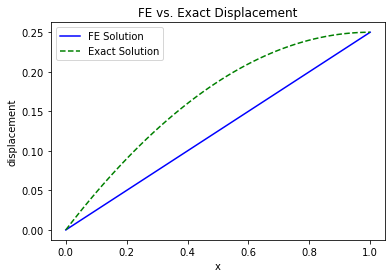

In [11]:
# Displacement plot
plt.plot(nodes, delta, 'b', label='FE Solution')
plt.xlabel('x')
plt.ylabel('displacement')
plt.title('FE vs. Exact Displacement')
x_values = np.linspace(0,L)
plt.plot(x_values, (1/(A*E)) * (-((q_0*(x_values**2))/2.0) + q_0*L*x_values), 'g--', label='Exact Solution')
plt.legend(loc='best')


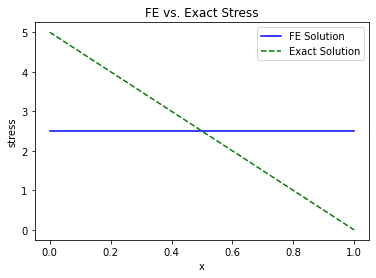

In [12]:
# Stress plot
for (elem_num, (node1,node2)) in enumerate(connectivity):
    if elem_num == 0:
        plt.plot([nodes[node1],nodes[node2]], [element_stress[elem_num], element_stress[elem_num]],'b',label='FE Solution')
    else:
        plt.plot([nodes[node1],nodes[node2]], [element_stress[elem_num], element_stress[elem_num]],'b')

plt.plot(x_values, ((q_0*L)/(A))*(1-x_values/L), 'g--', label='Exact Solution')

plt.xlabel('x')
plt.ylabel('stress')
plt.title('FE vs. Exact Stress')
plt.legend(loc='best')